<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

## 3. Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings("ignore")

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

### 3.1 Loading dataset and basic stats

In [2]:
df = pd.read_csv("train.csv")
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

We are given a minimal number of data fields here, consisting of:

* id: Looks like a simple rowID
* qid{1, 2}: The unique ID of each question in the pair
* question{1, 2}: The actual textual contents of the questions.
* is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

In [3]:
print("Number of data points:",df.shape[0])

Number of data points: 404290


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


* Looks like there are 2 null values in question2 column and 1 in question1, let's check and remove them.

### 3.2 Removing Null Values

In [5]:
print("Before removing null values: ", df.shape[0])
df.dropna( inplace = True)
print("After removing null values: ", df.shape[0])

Before removing null values:  404290
After removing null values:  404287


* All 3 null value rows has been removed.

### 3.2 Class Imbalance

<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

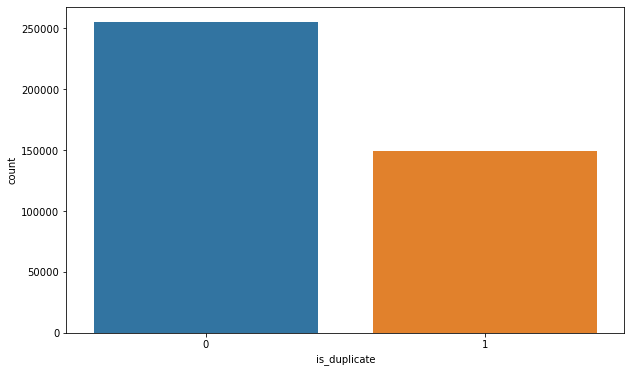

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x ='is_duplicate', data = df)

In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


* We have 36.92% positive class data, and 63.08% negative class data, hence our dataset is imbalance.

### 3.3 Repeated questions

### 3.3.1 Percentage of repeated questions

Total number of unique questions:  537929
Total number of repeated questions: 111778 (20.78%)



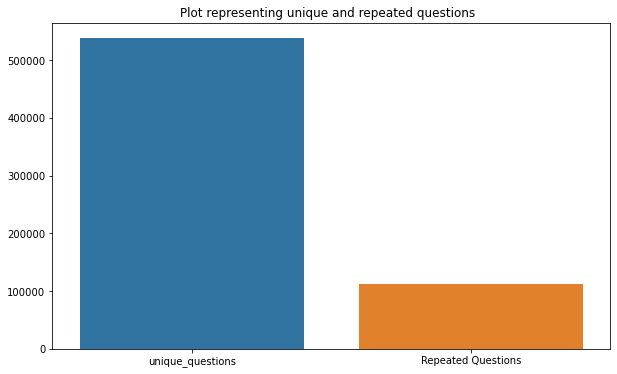

In [8]:
# Number of Repeated Questions
qids = pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_multiple_occurances = np.sum(qids.value_counts() > 1)

print("Total number of unique questions: ", unique_qs)
print("Total number of repeated questions: {} ({}%)\n".format(qs_multiple_occurances, round(qs_multiple_occurances/unique_qs*100,2)))

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_multiple_occurances]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

### 3.3.2 Number of occurances of each question

Maximum number of times a single question is repeated: 157



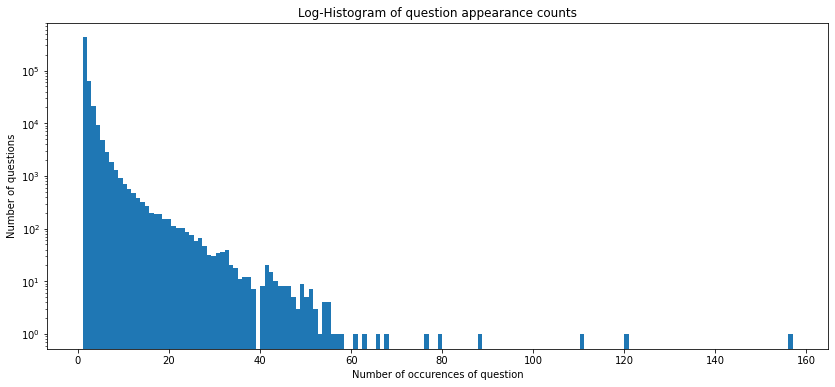

In [9]:
plt.figure(figsize=(14, 6))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

### 3.3.2 Checking for Duplicates

In [10]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count()
print ("Number of duplicate questions:", df.shape[0] - (pair_duplicates).shape[0])

Number of duplicate questions: 0


### 3.4 EDA Observations

* 17.2 % of the questions are repeated more than once.
* Maximum number of times a question has been repeated: 157.
* Here, we will not remove the repeated questions as it adds value to the entire data.
* For example - on question has been repeated 157 times, which means keywords in that question shows that there is possibility of questions with those keywords being asked again and again, they should be given more weightage.
* No duplicate(repeated pair of questions) data is present in the dataset.

## 4. Splitting data

In [11]:
y_true = df['is_duplicate'].values
df.drop('is_duplicate', axis=1, inplace=True)
df.reset_index(inplace=True)

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3, random_state = 42)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3, random_state = 42)

In [12]:
# Creating training dataset by adding X_train and y_train
X_train['is_duplicate'] = y_train.tolist()

In [13]:
X_train.head()

index      id    qid1    qid2  \
143707  143708  143708  227622  227623   
64378    64378   64378   85535  111883   
237191  237193  237193  348309  348310   
107904  107905  107905  177412  177413   
53516    53516   53516   33688   94596   

                                                question1  \
143707  What is the relation between Lord Ganesha and ...   
64378   Any flower delivery option in Chikkaballapur n...   
237191  What is the cost per book to publish one with ...   
107904  When you read a job posting that asks for atte...   
53516        How can I cancel the order in bigbasket.com?   

                                                question2  is_duplicate  
143707                     Who is sister of lord Ganesha?             0  
64378   Are there any basketball courts near Bellandur...             0  
237191  How much it cost to publish a 250 pages book i...             0  
107904  What all do you know about Business, Technolog...             0  
53516   I ordered items from Amazon but the address wa...             0

## 5 Basic Feature Extraction

### 5.1 Extracting basic features

Constructing 13 features mentioned below:
* **len_q1** : Length of question 1
* **len_q2** : Length of question 2
* **freq_q1** : Frequency of question 1
* **freq_q2** : Frequency of question 2
* **num_w_q1** : Number of words in question 1
* **num_w_q2** : Number of words in question 2
* **word_common** : Number of common words in question 1 & 2
* **word_total** : Sum of total number of words in question 1 & 2
* **word_share** : (num_common_w/sum_total_w)
* **freq_sum & freq_diff** 
* **len_sum & len_diff**

In [14]:
df.head()

index  id  qid1  qid2                                          question1  \
0      0   0     1     2  What is the step by step guide to invest in sh...   
1      1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2      2   2     5     6  How can I increase the speed of my internet co...   
3      3   3     7     8  Why am I mentally very lonely? How can I solve...   
4      4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  
0  What is the step by step guide to invest in sh...  
1  What would happen if the Indian government sto...  
2  How can Internet speed be increased by hacking...  
3  Find the remainder when [math]23^{24}[/math] i...  
4            Which fish would survive in salt water?

In [15]:
for dfx in tqdm([X_train, X_test, X_cv]):
    # Length Features
    dfx['len_q1'] = dfx['question1'].str.len()
    dfx['len_q2'] = dfx['question2'].str.len()
    dfx['len_sum'] = dfx['len_q1'] + dfx['len_q2']
    dfx['len_diff'] = abs(dfx['len_q1'] - dfx['len_q2'])

    # Frequency Features
    dfx['freq_q1'] = dfx.groupby('question1')['question1'].transform('size')
    dfx['freq_q2'] = dfx.groupby('question2')['question2'].transform('size')
    dfx['freq_sum'] = dfx['freq_q1'] + dfx['freq_q2']
    dfx['freq_diff'] = abs(dfx['freq_q1'] - dfx['freq_q2'])
    
    # Number of words features
    dfx['num_w_q1'] = dfx['question1'].map( lambda x: len(x.split(" ")))
    dfx['num_w_q2'] = dfx['question2'].map( lambda x: len(x.split(" ")))
    
    def normalized_word_common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return len(w1 & w2)
    dfx['word_common'] = dfx.apply(normalized_word_common, axis=1)
    
    def normalized_word_total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return len(w1) + len(w2)
    dfx['word_total'] = df.apply(normalized_word_total, axis=1)
    
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return len(w1 & w2)/(len(w1) + len(w2))
    dfx['word_share'] = df.apply(normalized_word_share, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:18<00:00, 26.22s/it]


In [16]:
X_train.head()

index      id    qid1    qid2  \
143707  143708  143708  227622  227623   
64378    64378   64378   85535  111883   
237191  237193  237193  348309  348310   
107904  107905  107905  177412  177413   
53516    53516   53516   33688   94596   

                                                question1  \
143707  What is the relation between Lord Ganesha and ...   
64378   Any flower delivery option in Chikkaballapur n...   
237191  What is the cost per book to publish one with ...   
107904  When you read a job posting that asks for atte...   
53516        How can I cancel the order in bigbasket.com?   

                                                question2  is_duplicate  \
143707                     Who is sister of lord Ganesha?             0   
64378   Are there any basketball courts near Bellandur...             0   
237191  How much it cost to publish a 250 pages book i...             0   
107904  What all do you know about Business, Technolog...             0   
53516   I ordered items from Amazon but the address wa...             0   

        len_q1  len_q2  len_sum  len_diff  freq_q1  freq_q2  freq_sum  \
143707      58      30       88        28        1        1         2   
64378       60      60      120         0        2        1         3   
237191      75      54      129        21        1        1         2   
107904     130      59      189        71        1        1         2   
53516       44     126      170        82        1        1         2   

        freq_diff  num_w_q1  num_w_q2  word_common  word_total  word_share  
143707          0        10         6            2          16    0.125000  
64378           1         8         9            4          17    0.235294  
237191          0        15        12            7          27    0.259259  
107904          0        23        10            3          33    0.090909  
53516           0         8        26            4          30    0.133333

### 5.2 Analysis of extracted features

In [17]:
print ("Minimum length of the questions in question1 : " , min(X_train['len_q1']))

print ("Minimum length of the questions in question2 : " , min(X_train['len_q2']))

print ("Number of Questions with minimum length [question1] :", X_train[X_train['len_q1']== min(X_train['len_q1'])].shape[0])
print ("Number of Questions with minimum length [question2] :", X_train[X_train['len_q2']== min(X_train['len_q2'])].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 12
Number of Questions with minimum length [question2] : 1


In [18]:
len(y_train)

198100

* Here we can see that few questions are 1 word in our training dataset.

**Feature: word_common**

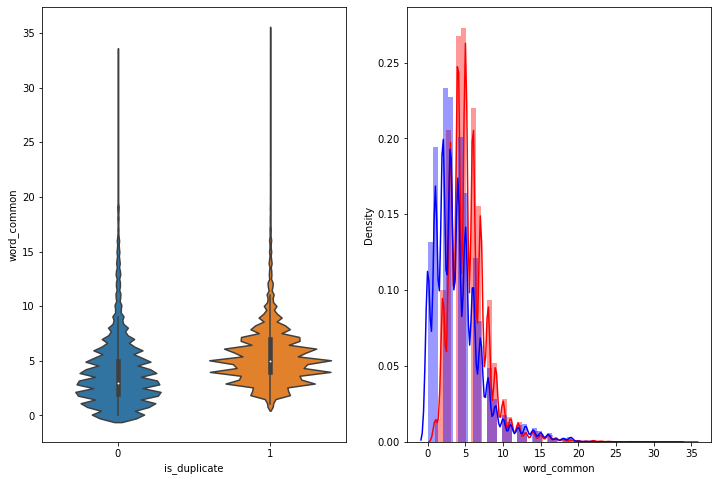

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = X_train)

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['word_common'] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['word_common'] , label = "0" , color = 'blue' )
plt.show()

* In voilen plot we can see than when common words are less, there's a high probability that questions are dissimilar.
* PDF plot is highly overlapping, we can't conclude anything significant.

**Feature: word_share**

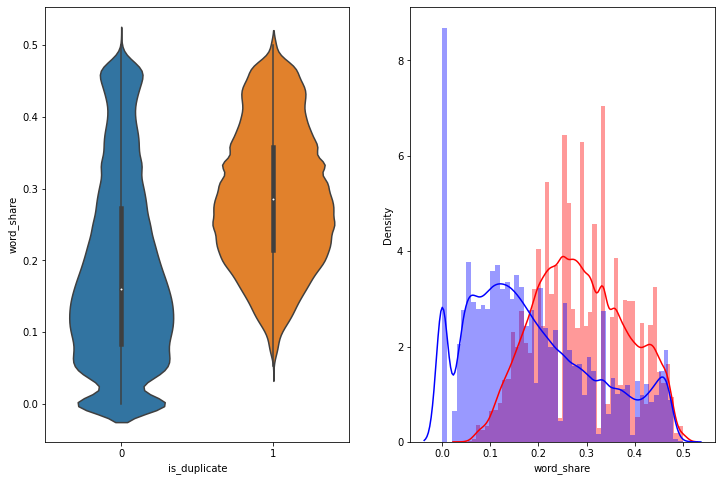

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = X_train)

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['word_share'] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['word_share'] , label = "0" , color = 'blue' )
plt.show()

* As we can see, if the "word share" is low then the probability of questions being dissimilar is more, while if the "word share" is more chances of questions being similar is high.

In [21]:
X_train.head()

index      id    qid1    qid2  \
143707  143708  143708  227622  227623   
64378    64378   64378   85535  111883   
237191  237193  237193  348309  348310   
107904  107905  107905  177412  177413   
53516    53516   53516   33688   94596   

                                                question1  \
143707  What is the relation between Lord Ganesha and ...   
64378   Any flower delivery option in Chikkaballapur n...   
237191  What is the cost per book to publish one with ...   
107904  When you read a job posting that asks for atte...   
53516        How can I cancel the order in bigbasket.com?   

                                                question2  is_duplicate  \
143707                     Who is sister of lord Ganesha?             0   
64378   Are there any basketball courts near Bellandur...             0   
237191  How much it cost to publish a 250 pages book i...             0   
107904  What all do you know about Business, Technolog...             0   
53516   I ordered items from Amazon but the address wa...             0   

        len_q1  len_q2  len_sum  len_diff  freq_q1  freq_q2  freq_sum  \
143707      58      30       88        28        1        1         2   
64378       60      60      120         0        2        1         3   
237191      75      54      129        21        1        1         2   
107904     130      59      189        71        1        1         2   
53516       44     126      170        82        1        1         2   

        freq_diff  num_w_q1  num_w_q2  word_common  word_total  word_share  
143707          0        10         6            2          16    0.125000  
64378           1         8         9            4          17    0.235294  
237191          0        15        12            7          27    0.259259  
107904          0        23        10            3          33    0.090909  
53516           0         8        26            4          30    0.133333

In [22]:
# Creating Duplicate of X_train
# X_temp = df.copy(deep = True)
# X_temp.head()

## 6. NLP Preprocessing

### 6.1 Preprocessing of text
* Converting text to lower case
* Removing http within text
* Removing special characters
* Expanding contractions
* Performing stemming
* Removal of Stopwords

In [23]:
# Lower Case
X_train['ques1'] = X_train['question1'].map( lambda x: x.lower())
X_train['ques2'] = X_train['question2'].map( lambda x: x.lower())

In [24]:
X_test['ques1'] = X_test['question1'].map( lambda x: x.lower())
X_test['ques2'] = X_test['question2'].map( lambda x: x.lower())

In [25]:
X_cv['ques1'] = X_cv['question1'].map( lambda x: x.lower())
X_cv['ques2'] = X_cv['question2'].map( lambda x: x.lower())

In [26]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from functools import reduce

stop_words = stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')
stop_words = set(stop_words)
# As a statement with no or not gives a very important informations about it

def text_preprocess(x):
    # Removing http within text
    x = re.sub(r'^https?:\/\/.*[\r\n]*', '', x)
    # Ref: https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python#comment110606799_40823105

    # Taking care of all the contractions
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                    .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                    .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                    .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                    .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                    .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                    .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = x.replace('?','')
    
    # Performing stemming 
    ps = PorterStemmer()
    sentence = "Programmers program with programming languages"
    word_tokens = word_tokenize(x) 
    # using reduce to apply stemmer to each word and join them back into a string
    x = reduce(lambda z, y: z + " " + ps.stem(y), word_tokens, "")
    
    # removing stopwords
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    # with no lower case conversion
    filtered_sentence = []
 
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    x = ' '.join(filtered_sentence)
    
    return x

In [27]:
X_train['ques1'] = X_train['ques1'].apply(text_preprocess)
X_train['ques2'] = X_train['ques2'].apply(text_preprocess)

In [28]:
X_test['ques1'] = X_test['ques1'].apply(text_preprocess)
X_test['ques2'] = X_test['ques2'].apply(text_preprocess)

In [29]:
X_cv['ques1'] = X_cv['ques1'].apply(text_preprocess)
X_cv['ques2'] = X_cv['ques2'].apply(text_preprocess)

**Note:** We are using stemming instead of lemmatization as our dataset is large and lemmatization is more computationally expensive.

In [30]:
X_train.head()

index      id    qid1    qid2  \
143707  143708  143708  227622  227623   
64378    64378   64378   85535  111883   
237191  237193  237193  348309  348310   
107904  107905  107905  177412  177413   
53516    53516   53516   33688   94596   

                                                question1  \
143707  What is the relation between Lord Ganesha and ...   
64378   Any flower delivery option in Chikkaballapur n...   
237191  What is the cost per book to publish one with ...   
107904  When you read a job posting that asks for atte...   
53516        How can I cancel the order in bigbasket.com?   

                                                question2  is_duplicate  \
143707                     Who is sister of lord Ganesha?             0   
64378   Are there any basketball courts near Bellandur...             0   
237191  How much it cost to publish a 250 pages book i...             0   
107904  What all do you know about Business, Technolog...             0   
53516   I ordered items from Amazon but the address wa...             0   

        len_q1  len_q2  len_sum  ...  freq_q2  freq_sum  freq_diff  num_w_q1  \
143707      58      30       88  ...        1         2          0        10   
64378       60      60      120  ...        1         3          1         8   
237191      75      54      129  ...        1         2          0        15   
107904     130      59      189  ...        1         2          0        23   
53516       44     126      170  ...        1         2          0         8   

        num_w_q2  word_common  word_total  word_share  \
143707         6            2          16    0.125000   
64378          9            4          17    0.235294   
237191        12            7          27    0.259259   
107904        10            3          33    0.090909   
53516         26            4          30    0.133333   

                                                    ques1  \
143707                  relation lord ganesha maa laxmiji   
64378   flower delivery option chikkaballapur near ban...   
237191  cost per book publish one 1k pages gujarat , i...   
107904  read job posting asks attention detail yet spe...   
53516                          cancel order bigbasket.com   

                                                    ques2  
143707                                sister lord ganesha  
64378          basketball courts near bellandur bangalore  
237191             much cost publish 250 pages book india  
107904                  know business , technology future  
53516   ordered items amazon address wrong item way ca...  

[5 rows x 22 columns]

### 6.2 Advanced Feature Extraction ( NLP & FuzzyWuzzy)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min length of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if Last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [31]:
SAFE_DIV = 0.0001
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in stop_words])
    q2_words = set([word for word in q2_tokens if word not in stop_words])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in stop_words])
    q2_stops = set([word for word in q2_tokens if word in stop_words])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["ques1"], x["ques2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["ques1"], x["ques2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["ques1"], x["ques2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["ques1"], x["ques2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["ques1"], x["ques2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["ques1"], x["ques2"]), axis=1)
    return df

In [32]:
X_train = extract_features(X_train)
X_train.head()

token features...
fuzzy features..


index      id    qid1    qid2  \
143707  143708  143708  227622  227623   
64378    64378   64378   85535  111883   
237191  237193  237193  348309  348310   
107904  107905  107905  177412  177413   
53516    53516   53516   33688   94596   

                                                question1  \
143707  What is the relation between Lord Ganesha and ...   
64378   Any flower delivery option in Chikkaballapur n...   
237191  What is the cost per book to publish one with ...   
107904  When you read a job posting that asks for atte...   
53516        How can I cancel the order in bigbasket.com?   

                                                question2  is_duplicate  \
143707                     Who is sister of lord Ganesha?             0   
64378   Are there any basketball courts near Bellandur...             0   
237191  How much it cost to publish a 250 pages book i...             0   
107904  What all do you know about Business, Technolog...             0   
53516   I ordered items from Amazon but the address wa...             0   

        len_q1  len_q2  len_sum  ...   ctc_max  last_word_eq  first_word_eq  \
143707      58      30       88  ...  0.399992           0.0            0.0   
64378       60      60      120  ...  0.333328           1.0            0.0   
237191      75      54      129  ...  0.499995           1.0            0.0   
107904     130      59      189  ...  0.076922           0.0            0.0   
53516       44     126      170  ...  0.166665           0.0            0.0   

        abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
143707           2.0       4.0               77                54          54   
64378            1.0       5.5               55                53          49   
237191           3.0       8.5               87                72          59   
107904           8.0       9.0               19                19          22   
53516            9.0       7.5               63                37          24   

        fuzz_partial_ratio  longest_substr_ratio  
143707                  74              0.650000  
64378                   66              0.255814  
237191                  58              0.230769  
107904                  42              0.117647  
53516                   53              0.259259  

[5 rows x 37 columns]

In [33]:
X_test = extract_features(X_test)
X_test.head()

token features...
fuzzy features..


index      id    qid1    qid2  \
380197  380200  380200  398338  511809   
325125  325127  325127  144864    4788   
219262  219264  219264  326093  129960   
231833  231835  231835  341728  341729   
316929  316931  316931  442049  442050   

                                                question1  \
380197  Was it appropriate for Meryl Streep to use her...   
325125                          Why do I have nightmares?   
219262                         How can I be more patient?   
231833      How do you know what is true and what is not?   
316929     What will go well with women's white t-shirts?   

                                                question2  len_q1  len_q2  \
380197  Should Meryl Streep be using her position to a...      91      66   
325125                    Why do I never have nightmares?      25      31   
219262           What is the best way to improve stamina?      26      40   
231833       How do we know what is true and what is not?      45      44   
316929       What will go well with men's white t-shirts?      46      44   

        len_sum  len_diff  ...   ctc_max  last_word_eq  first_word_eq  \
380197      157        25  ...  0.299997           0.0            0.0   
325125       56         6  ...  0.499975           1.0            0.0   
219262       66        14  ...  0.000000           0.0            0.0   
231833       89         1  ...  0.999967           1.0            1.0   
316929       90         2  ...  0.799984           1.0            1.0   

        abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
380197           4.0       8.0               60                48          51   
325125           1.0       1.5              100                77          77   
219262           3.0       2.5               26                26          26   
231833           0.0       3.0              100               100         100   
316929           0.0       5.0               96                81          96   

        fuzz_partial_ratio longest_substr_ratio  
380197                  59             0.333333  
325125                 100             0.909091  
219262                  46             0.125000  
231833                 100             0.928571  
316929                  92             0.666667  

[5 rows x 36 columns]

In [34]:
X_cv = extract_features(X_cv)
X_cv.head()

token features...
fuzzy features..


index      id    qid1    qid2  \
112202  112203  112203  183620  183621   
185789  185790  185790  283546  283547   
337726  337728  337728  465205  366778   
191398  191399  191399    9917     173   
99231    99231   99231   52096   30121   

                                                question1  \
112202               Who signed the Treaty of Versailles?   
185789  What are the qualities that I must have to be ...   
337726                Is Benjen Stark now a White Walker?   
191398  What were the major effects of the cambodia ea...   
99231   What are the best tricks to remember what you ...   

                                                question2  len_q1  len_q2  \
112202  What were the provisions of the Treaty of Vers...      36      53   
185789         How do I get selected in MTV Roadies show?      61      42   
337726                    Is Benjen Stark a white walker?      35      31   
191398  What were the major effects of the cambodia ea...     124     126   
99231   What are the best ways to retain the content o...      51      84   

        len_sum  len_diff  ...   ctc_max  last_word_eq  first_word_eq  \
112202       89        17  ...  0.666644           1.0            0.0   
185789      103        19  ...  0.399992           0.0            0.0   
337726       66         4  ...  0.999975           1.0            1.0   
191398      250         2  ...  0.599994           0.0            1.0   
99231       135        33  ...  0.285710           1.0            1.0   

        abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
112202           0.0       3.0               83                81          81   
185789           1.0       4.5               65                40          55   
337726           0.0       4.0              100               100         100   
191398           0.0      10.0               85                83          90   
99231            3.0       5.5               53                39          42   

        fuzz_partial_ratio longest_substr_ratio  
112202                  89             0.720000  
185789                  59             0.444444  
337726                 100             0.961538  
191398                  91             0.675325  
99231                   45             0.192308  

[5 rows x 36 columns]

### 6.2 Analysis of extracted features

### 6.2.1 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 

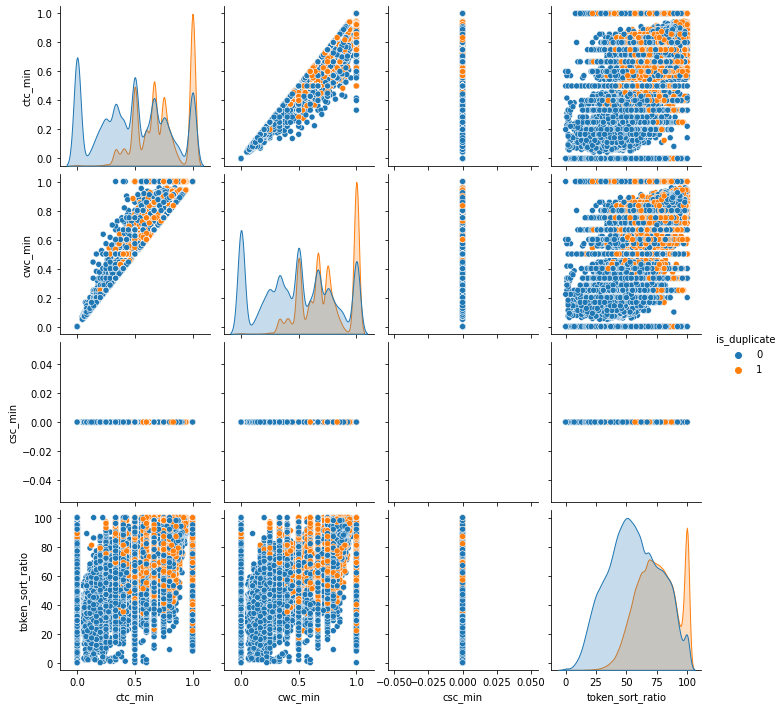

In [35]:
sns.pairplot(X_train[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

#### Oberservations:

* There is a lot of overlapping among the features and we can't differentiate the classes.

### 6.2.2 Voilen plot of some important features

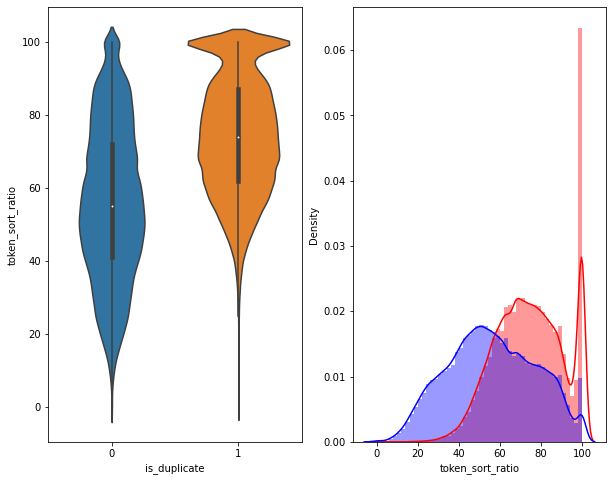

In [36]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = X_train[0:] , )

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

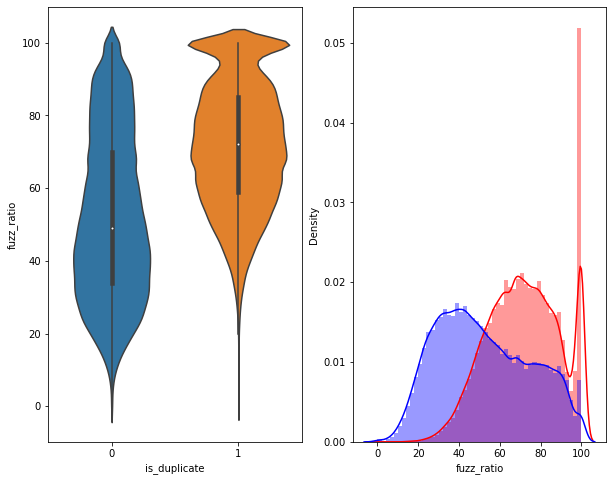

In [37]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = X_train[0:] , )

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

#### Oberservations:

* Both the voilen-plots look similar.
* When the fuzz ratio and the token sort ratios are less than 50, chaces of two questions being non-duplicates is much higher than if the ratios are greater than 50.
* For ratio scores more than 60-65, points are more 

### 6.3 Visualization after dimensionality reduction

### 6.3.1 T-SNE visualisation in 2D plane

In [38]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = X_train[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [39]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.045s...
[t-SNE] Computed neighbors for 5000 samples in 0.533s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.035481
[t-SNE] Computed conditional probabilities in 0.435s
[t-SNE] Iteration 50: error = 79.5067291, gradient norm = 0.0326659 (50 iterations in 2.202s)
[t-SNE] Iteration 100: error = 69.2876740, gradient norm = 0.0090994 (50 iterations in 1.809s)
[t-SNE] Iteration 150: error = 67.4448318, gradient norm = 0.0059474 (50 iterations in 2.243s)
[t-SNE] Iteration 200: error = 66.6288300, gradient norm = 0.0040073 (50 iterations in 2.229s)
[t-SNE] Iteration 250: error = 66.1267853, gradient norm = 0.0030524

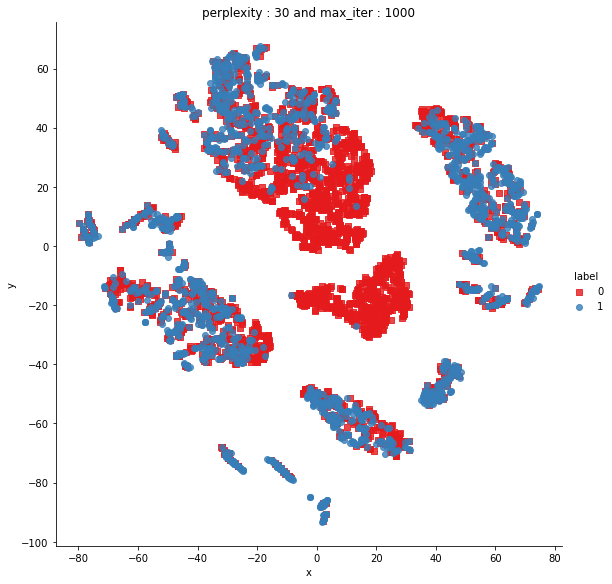

In [40]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

### 6.3.2 T-SNE visualisation in 3 dim space

In [41]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.032s...
[t-SNE] Computed neighbors for 5000 samples in 0.385s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.035481
[t-SNE] Computed conditional probabilities in 0.269s
[t-SNE] Iteration 50: error = 81.4479523, gradient norm = 0.0434010 (50 iterations in 4.001s)
[t-SNE] Iteration 100: error = 68.2413101, gradient norm = 0.0032703 (50 iterations in 3.092s)
[t-SNE] Iteration 150: error = 66.6932144, gradient norm = 0.0016880 (50 iterations in 2.728s)
[t-SNE] Iteration 200: error = 66.0890656, gradient norm = 0.0013135 (50 iterations in 2.238s)
[t-SNE] Iteration 250: error = 65.7417984, gradient norm = 0.0009389

In [42]:
from plotly.offline import iplot
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
iplot(fig, filename='3DBubble')

#### Observations:

* **PENDING** 

In [43]:
X_train.to_csv('X_train_featured.csv', index=False)

# 7 Featurizing text data with tfidf weighted word-vectors

#### Note:
We will find tf-idf w2v fpr preprocesses questions features - 'ques1' & 'ques2' and separately for original features
'question1' & 'question2'. Then we'll find the logloss of our basemodel and using both of these and will use the one which
will give more logloss score.


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings("ignore")

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

In [45]:
# pd.read_csv('X_train_featured.csv')

In [46]:
# preprocessed_ques = list(X_train['ques1']) + list(X_train['ques2'])
# questions = list(X_train['question1']) + list(X_train['question2'])

#### 7.1 Using preprocessed questions

In [47]:
# import spacy
# !python -m spacy download en_core_web_lg

In [48]:
# nlp = spacy.load('en_core_web_lg')

In [49]:
# import pickle

# with open('glove_6B_300d.txt', 'rb') as f:
#     model = pickle.load(f)
#     glove_words =  set(model.keys())

In [50]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer()
# tfidf.fit_transform(preprocessed_ques)
# # we are converting a dictionary with word as a key, and the idf as a value
# word2tfidf = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

### TFIDF vectorization of text data

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), max_features=1000)
def Tfidf_Vectorization(text_feature):
    tfidf.fit(text_feature)
    return tfidf.transform(text_feature)

In [52]:
train_ques1_tfidf, train_ques2_tfidf = Tfidf_Vectorization(X_train['ques1'].values), Tfidf_Vectorization(X_train['ques2'].values)
test_ques1_tfidf, test_ques2_tfidf = Tfidf_Vectorization(X_test['ques1'].values), Tfidf_Vectorization(X_test['ques2'].values)
cv_ques1_tfidf, cv_ques2_tfidf = Tfidf_Vectorization(X_cv['ques1'].values), Tfidf_Vectorization(X_cv['ques2'].values)

print("Shape of training questions afer vectorization:", train_ques1_tfidf.shape, y_train.shape)
print("Shape of testing questions after vectorization:", test_ques1_tfidf.shape, y_test.shape) 
print("Shape of cv questions after vectorization:", cv_ques1_tfidf.shape, y_cv.shape)

Shape of training questions afer vectorization: (198100, 1000) (198100,)
Shape of testing questions after vectorization: (121287, 1000) (121287,)
Shape of cv questions after vectorization: (84900, 1000) (84900,)


In [53]:
# def tfidf_w_w2v_fit(column):
#     tfidf_model = TfidfVectorizer()
#     tfidf_model.fit(column)
#     dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
#     tfidf_words = set(tfidf_model.get_feature_names())
#     return (tfidf_words, dictionary)

In [54]:
# def tfidf_w_w2v_vectorization(column):
#     tfidf_words, dictionary = tfidf_w_w2v_fit(column)
#     tfidf_w2v_vectors_lst = list()
#     for sentence in tqdm(column):
#         vector = np.zeros(300)
#         tf_idf_weight = 0
#         for word in sentence.split():
#             if (word in nlp) and (word in tfidf_words):
#                 vec = model[word]
#                 tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
#                 vector += (vec * tf_idf)
#                 tf_idf_weight += tf_idf
#         if tf_idf_weight != 0:
#             vector /= tf_idf_weight
#         tfidf_w2v_vectors_lst.append(vector)
#     return array(tfidf_w2v_vectors_lst)

In [55]:
# from numpy import array

In [56]:
# tra3 = X_train['ques1'].values
# X_train_question1_tfidf_w2v = tfidf_w_w2v_vectorization(tra3)  
# tes3 = X_test['ques1'].values
# X_test_question1_tfidf_w2v = tfidf_w_w2v_vectorization(tes3)
# print("After vectorizations")
# print(X_train_question1_tfidf_w2v.shape, y_train.shape)
# print(X_test_question1_tfidf_w2v.shape, y_test.shape) 
# print("="*100)

In [57]:
# tra4 = X_train['clean_question2'].values
# X_train_question2_tfidf_w2v = tfidf_w_w2v_vectorization(tra4)
# tes4 = X_test['clean_question2'].values
# X_test_question2_tfidf_w2v = tfidf_w_w2v_vectorization(tes4)
# print("After vectorizations")
# print(X_train_question2_tfidf_w2v.shape, y_train.shape)
# print(X_test_question2_tfidf_w2v.shape, y_test.shape) 
# print("="*100)

### Dropping string text features

In [58]:
X_train.drop(['question1', 'ques1', 'question2', 'ques2'], axis='columns', inplace=True)
X_test.drop(['question1', 'ques1', 'question2', 'ques2'], axis='columns', inplace=True)
X_cv.drop(['question1', 'ques1', 'question2', 'ques2'], axis='columns', inplace=True)

In [59]:
X_train

index      id    qid1    qid2  is_duplicate  len_q1  len_q2  len_sum  \
143707  143708  143708  227622  227623             0      58      30       88   
64378    64378   64378   85535  111883             0      60      60      120   
237191  237193  237193  348309  348310             0      75      54      129   
107904  107905  107905  177412  177413             0     130      59      189   
53516    53516   53516   33688   94596             0      44     126      170   
...        ...     ...     ...     ...           ...     ...     ...      ...   
186881  186882  186882  284953  284954             0     150     115      265   
335542  335544  335544   60738   94752             1      31      34       65   
168127  168128  168128  259467  260496             0      60      62      122   
78493    78493   78493  133832  133833             0      59      87      146   
389205  389208  389208  521684  128256             0      54      62      116   

        len_diff  freq_q1  ...   ctc_max  last_word_eq  first_word_eq  \
143707        28        1  ...  0.399992           0.0            0.0   
64378          0        2  ...  0.333328           1.0            0.0   
237191        21        1  ...  0.499995           1.0            0.0   
107904        71        1  ...  0.076922           0.0            0.0   
53516         82        1  ...  0.166665           0.0            0.0   
...          ...      ...  ...       ...           ...            ...   
186881        35        1  ...  0.214284           0.0            0.0   
335542         3        3  ...  0.499988           1.0            0.0   
168127         2        2  ...  0.833319           1.0            1.0   
78493         28        1  ...  0.000000           0.0            0.0   
389205         8        1  ...  0.428565           0.0            1.0   

        abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
143707           2.0       4.0               77                54          54   
64378            1.0       5.5               55                53          49   
237191           3.0       8.5               87                72          59   
107904           8.0       9.0               19                19          22   
53516            9.0       7.5               63                37          24   
...              ...       ...              ...               ...         ...   
186881           2.0      13.0               51                47          29   
335542           2.0       3.0              100                69          69   
168127           1.0       5.5              100                92          92   
78493            6.0       7.0               33                29          20   
389205           1.0       6.5               64                67          62   

        fuzz_partial_ratio  longest_substr_ratio  
143707                  74              0.650000  
64378                   66              0.255814  
237191                  58              0.230769  
107904                  42              0.117647  
53516                   53              0.259259  
...                    ...                   ...  
186881                  36              0.119048  
335542                 100              0.900000  
168127                  94              0.918919  
78493                   36              0.153846  
389205                  57              0.277778  

[198100 rows x 33 columns]

In [60]:
from scipy import sparse

X_train_tfidf = np.hstack((sparse.csr_matrix(X_train.to_numpy()), train_ques1_tfidf, train_ques2_tfidf))

In [61]:
X_train_tfidf = np.hstack((X_train, train_ques1_tfidf.toarray(), train_ques2_tfidf.toarray()))
X_test_tfidf = np.hstack((X_test, test_ques1_tfidf.toarray(), test_ques2_tfidf.toarray()))
X_cv_tfidf = np.hstack((X_cv, cv_ques1_tfidf.toarray(), cv_ques2_tfidf.toarray()))

print("Shape of final training data matrix:", X_train_tfidf.shape, y_train.shape)
print("Shape of final testing data matrix:", X_test_tfidf.shape, y_test.shape)
print("Shape of final testing data matrix:", X_cv_tfidf.shape, y_cv.shape)

Shape of final training data matrix: (198100, 2033) (198100,)
Shape of final testing data matrix: (121287, 2032) (121287,)
Shape of final testing data matrix: (84900, 2032) (84900,)


In [ ]:
print("Shape of final training data matrix:", X_train_tfidf.shape, y_train.shape)

### Storing vectorized final ouputs in pickle files

In [62]:
import pickle

with open('tfidf.pkl', 'wb') as file:
    pickle.dump([X_train_tfidf, y_train, X_test_tfidf, y_test, X_cv_tfidf, y_cv], file)

In [63]:
with open('tfidf.pkl', 'rb') as file:
    X_train_tfidf, y_train, X_test_tfidf, y_test, X_cv_tfidf, y_cv = pickle.load(file)

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
# from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

### Building confusion matrix

In [74]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(y_test, y_pred):
    C = confusion_matrix(y_test, y_pred)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()    

### Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8852931643752523


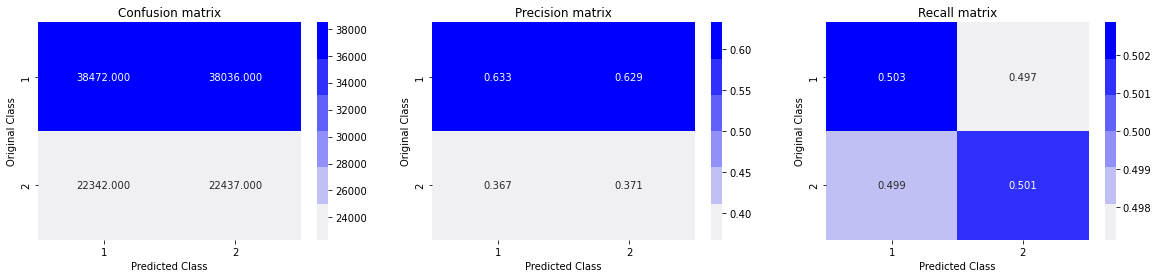

In [76]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
y_pred = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    y_pred[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, y_pred, eps=1e-15))

y_pred =np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred)

In [78]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train_tfidf, label=y_train)
d_test = xgb.DMatrix(X_test_tfidf, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train_tfidf,y_train)
y_pred = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.67335	valid-logloss:0.69858
[10]	train-logloss:0.51171	valid-logloss:0.76608
[20]	train-logloss:0.39683	valid-logloss:0.85055


XGBoostError: bad allocation